Connected to my_env (Python 3.9.18)

### Comparing ChIP-seq TF to genomic location with sliding window method predictions

This notebook uses ChIP-seq peaks from ChIP-Atlas as the input for calculating sliding window TF to peak binding scores. As the sliding window score attempts to match TFs to peaks, we can check the accuracy of our methods by comparing which TFs are predicted to bind the ChIP-seq peaks against the TFs that actually bound those locations.

The first thing that we need to do is to download and clean the ChIP-seq dataset to only contain the TF `gene_id`s and the formatted `peak_id`s.

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

In [2]:
!hostnamectl

   Static hostname: psh01com1hcom37
         Icon name: computer-server
           Chassis: server
        Machine ID: a0e3b195026b4efbba9be5cc7fb6b874
           Boot ID: ae5b7b962cc94cd09ec7e54c81aed21f
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [ ]:
import os
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt
from grn_inference.utils import read_ground_truth, merge_dataset_with_ground_truth

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
output_dir = os.path.join(base_dir, "output/chipseq_sliding_window")
tmp_dir = os.path.join(output_dir, "tmp")

os.makedirs(ground_truth_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

In [6]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

In [ ]:
chip_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_bed = pybedtools.BedTool(chip_bed_file)
chip_bed_df = chip_bed.to_dataframe()
chip_bed_nohead = chip_bed_df.iloc[1:, :].dropna()

chip_bed_nohead["gene_id"] = chip_bed_nohead["name"].apply(extract_gene_name)
chip_bed_cleaned = chip_bed_nohead[["chrom", "start", "end", "gene_id"]]

# Set the peak_id as the formatted peak location
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

chip_tf_to_peak = chip_bed_cleaned[["gene_id", "peak_id"]]
chip_tf_to_peak

Now that we have the ChIP-Atlas peaks in the format that we want, we can save it to the ground truth directory for later

In [5]:
chip_tf_to_peak.to_csv(os.path.join(ground_truth_dir, "chipatlas_mESC.csv"), header=True, index=False)

### Creating the Homer peaks file

Next, we need to format the peaks to follow the same requirements as the Homer peaks file. The sliding window method also uses this format for convenience.

> HOMER peak files should have at minimum 5 columns (separated by TABs, additional columns will be ignored:
> - Column1: Unique Peak ID
> - Column2: chromosome
> - Column3: starting position
> - Column4: ending position
> - Column5: Strand (+/- or 0/1, where 0="+", 1="-")

In [8]:
chip_bed_cleaned = pd.read_csv(os.path.join(ground_truth_dir, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=False)
chip_tf_to_peak = chip_bed_cleaned[["source_id", "peak_id"]].rename(columns={"source_id":"gene_id"})
chip_tf_to_peak

,gene_id,peak_id
0,SMAD4,chr1:3003564-3003922
1,CTCF,chr1:3012605-3012815
2,CTCF,chr1:3012635-3012824
3,EPITOPE,chr1:3031387-3031654
4,SMAD4,chr1:3031454-3031677
...,...,...
7734461,REST,chrY_JH584303_random:135985-136047
7734462,REST,chrY_JH584303_random:135985-136048
7734463,REST,chrY_JH584303_random:135986-136045
7734464,REST,chrY_JH584303_random:135989-136043


In [31]:
# Format the DataFrame to follow the requirements for the Homer peaks file (used for both Homer and sliding window)
homer_peaks = chip_bed_cleaned[["peak_id", "chrom", "start", "end"]]
homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)
homer_peaks = homer_peaks[["chrom", "start", "end", "peak_id"]]
homer_peaks

/tmp/ipykernel_462216/2201842266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
/tmp/ipykernel_462216/2201842266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)


,chrom,start,end,peak_id
1,chr1,3003564,3003922,chr1:3003564-3003922
2,chr1,3012605,3012815,chr1:3012605-3012815
3,chr1,3012635,3012824,chr1:3012635-3012824
4,chr1,3031387,3031654,chr1:3031387-3031654
5,chr1,3031454,3031677,chr1:3031454-3031677
...,...,...,...,...
7624387,chrY_JH584303_random,135985,136047,chrY_JH584303_random:135985-136047
7624388,chrY_JH584303_random,135985,136048,chrY_JH584303_random:135985-136048
7624389,chrY_JH584303_random,135986,136045,chrY_JH584303_random:135986-136045
7624390,chrY_JH584303_random,135989,136043,chrY_JH584303_random:135989-136043


This is a huge file - we dont need to test the method using all of them. We will take a sample to run the scoring on.

In [24]:
homer_peaks_sample = homer_peaks.sample(frac=0.05)

If we save the ChIP-seq peaks as `homer_peaks.txt` to the `tmp` directory of the output folder, then they will be used to calculate the sliding window and Homer scores

In [4]:
homer_peak_path = os.path.join(tmp_dir, "homer_peaks.txt")

In [16]:
homer_peaks.to_csv(homer_peak_path, sep="\t", header=True, index=False)

Reload `homer_peaks` if needed

In [13]:
homer_peaks = pd.read_csv(homer_peak_path, sep="\t", header=0, index_col=None)

In [32]:
homer_peaks

,chrom,start,end,peak_id
1,chr1,3003564,3003922,chr1:3003564-3003922
2,chr1,3012605,3012815,chr1:3012605-3012815
3,chr1,3012635,3012824,chr1:3012635-3012824
4,chr1,3031387,3031654,chr1:3031387-3031654
5,chr1,3031454,3031677,chr1:3031454-3031677
...,...,...,...,...
7624387,chrY_JH584303_random,135985,136047,chrY_JH584303_random:135985-136047
7624388,chrY_JH584303_random,135985,136048,chrY_JH584303_random:135985-136048
7624389,chrY_JH584303_random,135986,136045,chrY_JH584303_random:135986-136045
7624390,chrY_JH584303_random,135989,136043,chrY_JH584303_random:135989-136043


Next, we run `run_sliding_window_on_chipseq_peaks.sh` in the `dev/testing_scripts` directory

In [38]:
!sbatch /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/testing_scripts/run_sliding_window_on_chipseq_peaks.sh

Submitted batch job 3384960


Once the sliding window calculation is done, we can read in the output.

In [9]:

sliding_window_df = pd.read_parquet(os.path.join(output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")
sliding_window_df = sliding_window_df.reset_index(drop=True)
sliding_window_df

,peak_id,source_id,sliding_window_score
0,chr17:46704666-46705502,Ascl1,18836.157784
1,chr17:3456010-3456318,Ascl1,6543.452178
2,chr17:56255512-56256229,Ascl1,15508.133754
3,chr17:69382560-69382744,Ascl1,4256.191542
4,chr17:86555341-86555555,Ascl1,4312.891574
...,...,...,...
7488346,chr11:51936197-51936397,Zfp335,7371.634079
7488347,chr11:100846598-100846664,Zfp335,2121.398070
7488348,chr11:108891288-108891643,Zfp335,13014.262983
7488349,chr11:87771063-87771282,Zfp335,8039.550073


We can use the `chip_tf_to_peak` object that we created from the ChIP-Atlas file to check our work. Since we sampled the ChIP-Atlas peaks before running the sliding window calculations, we need to subset `chip_tf_to_peak` to only contain those peaks.

In [10]:
sliding_window_df["source_id"] = sliding_window_df["source_id"].str.upper()
chip_tf_to_peak["gene_id"] = chip_tf_to_peak["gene_id"].str.upper()

In [11]:
chip_tf_to_peak_sub = chip_tf_to_peak[
    (chip_tf_to_peak["peak_id"].isin(sliding_window_df["peak_id"])) &
    (chip_tf_to_peak["gene_id"].isin(sliding_window_df["source_id"]))
    ]
chip_tf_to_peak_sub

,gene_id,peak_id
400,REST,chr1:3670770-3670855
483,CTCF,chr1:3672215-3672538
1830,TCF3,chr1:4779120-4779177
2514,CTCF,chr1:5017906-5018204
2654,CTCF,chr1:5070240-5070596
...,...,...
7717530,CTCF,chrY:11857983-11858300
7721383,CTCF,chrY:35978139-35978355
7721390,CTCF,chrY:35978154-35978351
7721566,CTCF,chrY:37551909-37552175


We then combine the TF-peak mapping from ChIP-Atlas with the TF-peak mapping from the sliding window score by merging the two DataFrames on `peak_id`.

In [12]:

merged_df = pd.merge(chip_tf_to_peak_sub, sliding_window_df, on="peak_id", how="inner")
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "sliding_window_gene"})
merged_df = merged_df[["chip_gene", "sliding_window_gene", "peak_id", "sliding_window_score"]]
merged_df

,chip_gene,sliding_window_gene,peak_id,sliding_window_score
0,REST,ASCL1,chr1:3670770-3670855,1776.750220
1,REST,CDX2,chr1:3670770-3670855,1051.804907
2,REST,CEBPA,chr1:3670770-3670855,1003.005789
3,REST,CREB1,chr1:3670770-3670855,1227.633637
4,REST,CTCF,chr1:3670770-3670855,1944.025267
...,...,...,...,...
6252250,CTCF,TWIST1,chrY:63471202-63471366,4365.138945
6252251,CTCF,WT1,chrY:63471202-63471366,4966.008166
6252252,CTCF,ZEB1,chrY:63471202-63471366,2478.835532
6252253,CTCF,ZFP281,chrY:63471202-63471366,2482.208951


In [13]:
merged_df.to_csv(os.path.join(output_dir, "chipseq_sliding_window_merged.csv"), header=True, index=False)

We can extract the correct predictions and the incorrect predictions, and see how the sliding window scores vary between them.

In [ ]:
import dask.dataframe as dd


merged_ddf = dd.from_pandas(merged_df, npartitions=100)
merged_df_sample = merged_ddf.sample(frac=0.05, random_state=42).compute()


correct_predictions = merged_df_sample[merged_df_sample["chip_gene"].str.upper() == merged_df_sample["sliding_window_gene"].str.upper()]
incorrect_predictions = merged_df_sample[merged_df_sample["chip_gene"].str.upper() != merged_df_sample["sliding_window_gene"].str.upper()]

print(f"Num correct predictions: {len(correct_predictions)}")
print(f"Num incorrect predictions: {len(incorrect_predictions)}")

print(f"Num unique correct TFs: {len(correct_predictions.drop_duplicates(subset=['chip_gene', 'sliding_window_gene']))}")
print(f"Num unique incorrect TFs: {len(incorrect_predictions.drop_duplicates(subset=['chip_gene', 'sliding_window_gene']))}")

Num correct predictions: 3554
Num incorrect predictions: 309046
Num unique correct TFs: 15
Num unique inorrect TFs: 1227


Since each TF and peak has a potential binding score, there will be a lot more incorrect predictions than correct predictions. We will sample each DataFrame by the one with the minimum number of rows so they are equal in length.

In [15]:
correct_prediction_scores = correct_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Correct TF Binding Predictions").reset_index(drop=True)

incorrect_prediction_scores = incorrect_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Incorrect TF Binding Predictions").reset_index(drop=True)

print(f"Num correct predictions: {len(correct_prediction_scores)}")
print(f"Num incorrect predictions: {len(incorrect_prediction_scores)}")

Num correct predictions: 3554
Num incorrect predictions: 3554


Now that we have extracted the correct and incorrect scores, we will merge them to create a new dataframe containing just the correct and incorrect scores.

In [16]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

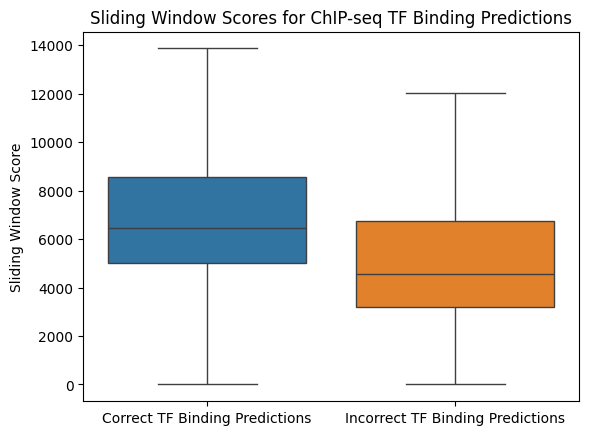

In [18]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df, showfliers=False)
a.set_ylabel("Sliding Window Score")
a.set_title("Sliding Window Scores for ChIP-seq TF Binding Predictions")
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_boxplot.png", dpi=200)

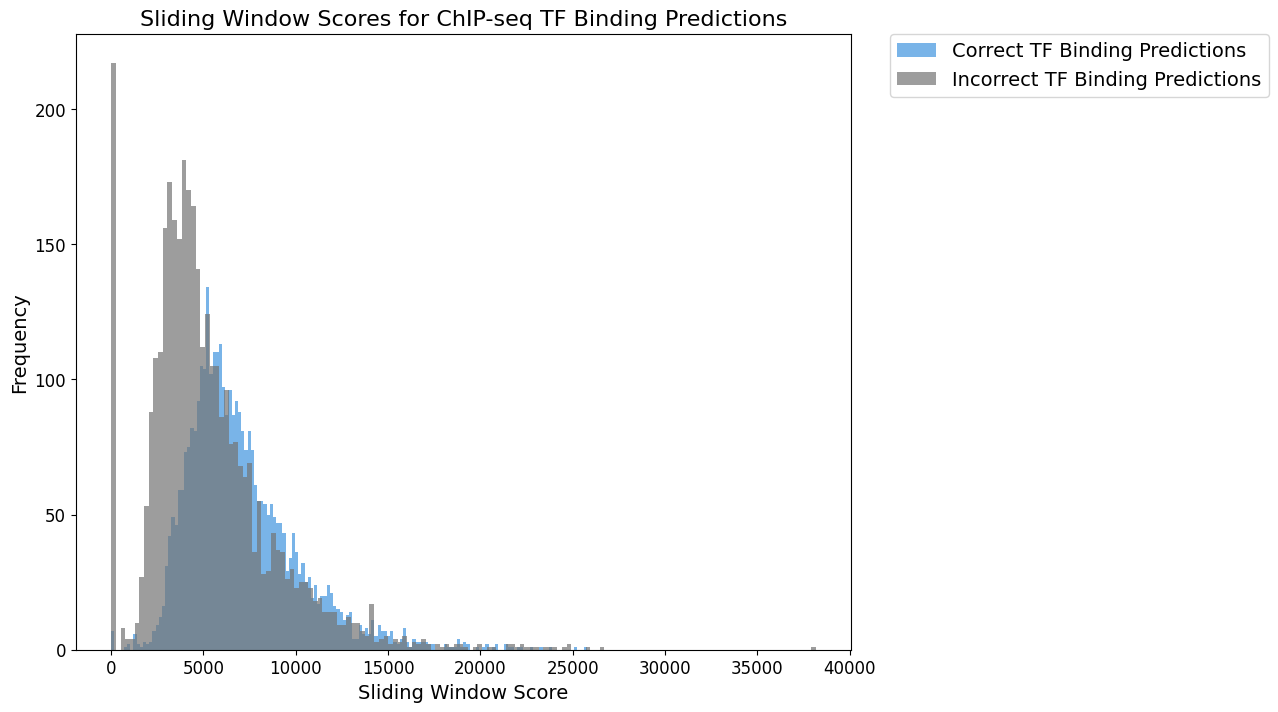

In [20]:
plt.figure(figsize=(10,8))
plt.hist(
    pred_df["Correct TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    pred_df["Incorrect TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#747474',
    label="Incorrect TF Binding Predictions"
)
plt.title("Sliding Window Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Sliding Window Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_histogram.png", dpi=200)